# 6.6 DataAugmentation

### 导入utils中的辅助函数

In [1]:
from utils import *

## 读入猫狗数据

In [2]:
%ls ../dataset/CatDog
%ls ../dataset/CatDog/train
%ls ../dataset/CatDog/validation

train/  validation/
cats/  dogs/
cats/  dogs/


In [3]:
batch_size = 10 # 指定batch_size 
IMSIZE = 128
data_dir = '../dataset/CatDog' # 指定图片路径

## 数据准备

In [4]:
# 测试集无需数据增强，将读入的图片resize后，转换成tensor
val_transform = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)), 
    transforms.ToTensor()
])

In [5]:
# 训练集进行数据增强
train_transform = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)), # Resize成规定尺寸
    transforms.RandomCrop(IMSIZE, padding=8), # 随机裁剪
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor()
])

In [6]:
# 准备dataset，使用torchvision.datasets.ImageFolder读入图片，指定变换形式
train_set = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
val_set = torchvision.datasets.ImageFolder(root=os.path.join(data_dir,'validation'), transform=val_transform)
# 准备dataloaer
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=4)  # 进行打乱
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4) 

torch.Size([10, 3, 128, 128])
torch.Size([10])


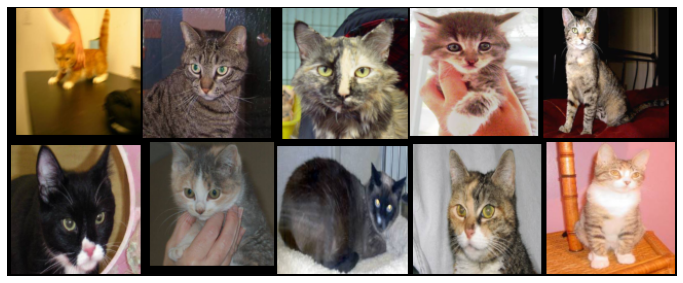

In [7]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(train_loader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)
plt.figure(figsize=(12, 6))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=5).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

借助PyTorch内置的nn.Sequential类构建模型。

## 深模型

In [8]:
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__() 
        ## 构建卷积层
        layers = []
        # 建立7层模型，每层结构相同
        for i in range(7):
            in_planes = 3 if i == 0 else 20 # 除了第一层输入为3，其余输入为20（卷积个数）
            layers += [nn.Conv2d(in_planes, 20, kernel_size=2, padding=1),
                                         nn.BatchNorm2d(20), # BN
                                         nn.ReLU(), # 非线性变换
                                         nn.MaxPool2d(kernel_size=2)] #池化
        self.cnn = nn.Sequential(*layers) # 将7层通过nn.Sequential连接起来
        # 构建全连接层 
        self.fc = nn.Sequential(
            nn.Linear(20, 2)
        )
    # 前向计算流程
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)  # 在卷积操作后，输出仍是tensor，需要进行flatten拉直，再接全连接层
        out = self.fc(out)
        return out

In [9]:
def test():
    X = torch.randn((1, 3, IMSIZE, IMSIZE))
    net = DeepModel()
    out = net(X)
    print(out.shape)
    
test()

torch.Size([1, 2])


In [ ]:
deep_model = DeepModel().cuda()
lr = 1e-3
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)  # 设置优化器
epochs = 2
history = train(deep_model, optimizer, train_loader, val_loader, epochs=epochs)  # 实施训练

Epoch [1/2], time: 21.84s, loss: 0.0430, acc: 0.9908, val_loss: 4.3849, val_acc: 0.5000
